# Neural Network model to identify yoga poses

This notebook explores model approaches for an optimal classification of yoga poses.

## Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score


from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Data Preprocessing

First, we download import the pose data into the notebook. For the tryout, we started out without visibility and presence parameters, only using coordinates. This of course can be changed at any time. We a currently in the phase of trying out what would work best for the model accuracy.

In [79]:
df = pd.read_csv('pose_landmark_data.csv')
cols_to_drop = [col for col in df.columns if col.endswith('visibility') or col.endswith('presence')]
# cols_to_drop = [col for col in df.columns if col.endswith('presence')]
# cols_to_drop = [col for col in df.columns if col.endswith('visibility')]
cols_to_drop.append('filename')
df = df.drop(columns= cols_to_drop)
df

,kp0_x,kp0_y,kp0_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,kp30_x,kp30_y,kp30_z,kp31_x,kp31_y,kp31_z,kp32_x,kp32_y,kp32_z,pose
0,0.385088,0.702528,-0.004816,0.364045,0.705285,-0.031445,0.361666,0.700772,-0.031418,0.359247,...,0.870051,0.811650,0.241516,0.781881,0.930616,-0.215838,0.763475,0.904605,0.165073,downdog
1,0.715758,0.547609,0.009604,0.729912,0.527488,0.021406,0.729571,0.523913,0.021355,0.728997,...,0.261937,0.680302,-0.029372,0.380548,0.670513,0.219000,0.336641,0.713165,-0.141662,downdog
2,0.530292,0.608646,-0.049306,0.514618,0.623104,-0.070189,0.510664,0.621608,-0.070218,0.506621,...,0.853871,0.763474,0.147834,0.806643,0.812826,-0.256742,0.792238,0.797374,0.089617,downdog
3,0.492200,0.676890,-0.019580,0.505274,0.690638,-0.009582,0.507291,0.688784,-0.009578,0.509701,...,0.139040,0.773426,0.103013,0.242576,0.769081,0.230293,0.223391,0.795712,0.024180,downdog
4,0.443851,0.731885,-0.001135,0.431531,0.750095,-0.030704,0.429421,0.748873,-0.030640,0.427386,...,0.735194,0.849913,0.253985,0.664935,0.915146,-0.179419,0.657539,0.891609,0.174451,downdog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,0.367327,0.136058,-0.131961,0.382764,0.172087,-0.148830,0.383088,0.179727,-0.148875,0.383502,...,0.733950,0.857140,0.260169,0.781965,0.876409,-0.285529,0.775252,0.867445,0.140146,cobra
2807,0.488189,0.236331,-1.442468,0.503591,0.229749,-1.403434,0.514425,0.231271,-1.403702,0.525101,...,0.369359,0.633295,2.877213,0.559438,0.679885,2.803286,0.381968,0.683228,2.805098,cobra
2808,0.807677,0.237775,-0.186827,0.789169,0.243436,-0.135315,0.787725,0.246924,-0.135315,0.785724,...,0.181038,0.851754,-0.085535,0.136738,0.883896,0.369380,0.102801,0.915968,-0.201291,cobra
2809,0.498881,0.306176,-2.330929,0.532501,0.272223,-2.285773,0.551982,0.271076,-2.285689,0.569576,...,0.432241,0.501459,2.951475,0.636693,0.531014,2.843509,0.396180,0.553856,2.806558,cobra


In [80]:
n_rows_to_keep = 300

cobra_df = df[df['pose'] == 'cobra']
non_cobra_df = df[df['pose'] != 'cobra']
cobra_df_lite = cobra_df.sample(n = n_rows_to_keep, random_state=2)
df = pd.concat([non_cobra_df, cobra_df_lite])

revolved_triangle_df = df[df['pose'] == 'revolved_triangle']
non_revolved_triangle_df = df[df['pose'] != 'revolved_triangle']
revolved_triangle_df_lite = revolved_triangle_df.sample(n = n_rows_to_keep, random_state=2)
df = pd.concat([non_revolved_triangle_df, revolved_triangle_df_lite])

df['pose'].value_counts()

pose
cobra                300
revolved_triangle    300
dance                277
boat                 248
downdog              210
warrior              208
plow                 194
camel                192
halfmoon             168
heron                121
plank                104
goddess               95
akarna                67
tree                  53
Name: count, dtype: int64

We then split the data into independent variables (X) and dependent variables (y). The validation split can be either done manually here (currently executed option) or within the model fitting with the data. As described below, the results are a lot better with the validation split within the model fitting (how it is not currently done). This should not be the case and needs to investigated further.



Afterwards, we transform the targets into number values, scale the features, and OneHotEncode the targets.

In [81]:
X = df[df['pose'].isin(['downdog', 'tree', 'goddess', 'warrior', 'boat', 'cobra'])].iloc[:, :len(df.columns)-1]
# X = df.iloc[:, :len(df.columns)-1]

y = df.loc[df['pose'].isin(['downdog', 'tree', 'goddess', 'warrior', 'boat', 'cobra',]), 'pose']
# y = df['pose']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=13,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=13,
                                                  stratify=y_train)

numdict_y = {label: idx for idx, label in enumerate(np.unique(y))}
y_train_numerical = np.array([numdict_y[label] for label in y_train])
y_test_numerical = np.array([numdict_y[label] for label in y_test])
y_val_numerical = np.array([numdict_y[label] for label in y_val])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

y_train_encoded = to_categorical(y_train_numerical)
y_test_encoded = to_categorical(y_test_numerical)
y_val_encoded = to_categorical(y_val_numerical)


## Model Setup

In [82]:

def model_init():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(numdict_y), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = model_init()


## Model Fitting and Testing

Here fit the model on the train data. For validation, we have two options: 

1. We create the validation data manually. The advantage is that we can stratify the split, meaning keeping it proportionally equivalent amongs targets, no matter the size of the data points for each (which fluctuata a lot).This is how it is currently done. The results are surprisingly worse than with option 2.

2. We can create a direct validation split within fitting the model with validation_split. This cuts off the lower X% number given. The results are a lot better. While therefore theoretically preferable, this should not be the case and needs to investigated further.

In [83]:
len(X_train_scaled)

623

Epoch 1/50
5/5 [==============================] - 1s 61ms/step - loss: 1.7812 - accuracy: 0.3451 - val_loss: 1.0656 - val_accuracy: 0.6538
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.9307 - accuracy: 0.6790 - val_loss: 0.6552 - val_accuracy: 0.7949
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6678 - accuracy: 0.7721 - val_loss: 0.5233 - val_accuracy: 0.8333
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5468 - accuracy: 0.8122 - val_loss: 0.4459 - val_accuracy: 0.8654
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4671 - accuracy: 0.8459 - val_loss: 0.4136 - val_accuracy: 0.8846
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4301 - accuracy: 0.8732 - val_loss: 0.3919 - val_accuracy: 0.8910
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4259 - accuracy: 0.8700 - val_loss: 0.3353 - val_accuracy: 0.9103
Epoch 8/50
5/5 [===========

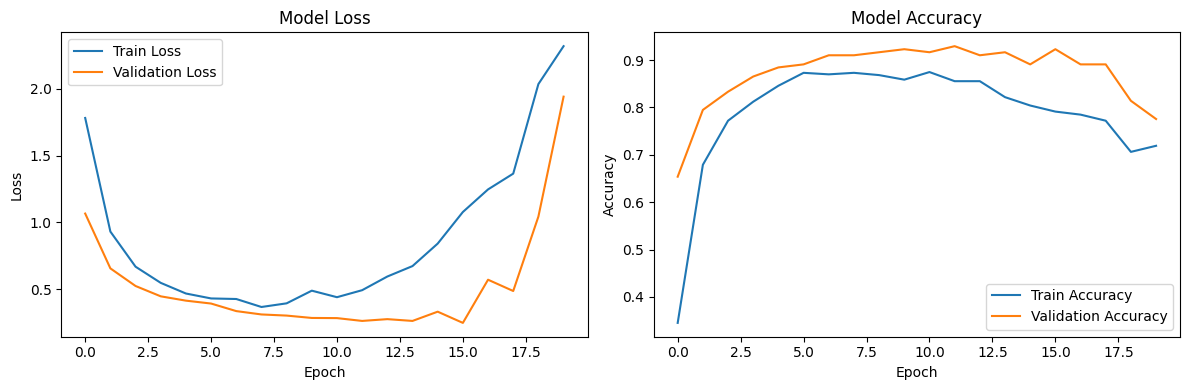

11/11 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.9313
Test Accuracy: 93.13%
Test Loss: 0.23293523490428925


In [84]:


es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=50,
    batch_size = 128,
    # validation_split = 0.3,
    validation_data=(X_val_scaled, y_val_encoded),
    verbose=1,
    callbacks=[es]
)

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

results = model.evaluate(X_test_scaled, y_test_encoded, verbose=1)
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')
